<a href="https://colab.research.google.com/github/XuShuqi7/NCrystal-based_Neutron_Imaging_Fitting_Script/blob/main/Fit_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble (adopted from ncrystal-notebook)

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    %pip -q install ncrystal[plot] ipympl
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
    %matplotlib inline
else:
    %matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  4000000, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


# Extinction and texture plugins

In [2]:
%pip install "git+https://github.com/XuShuqi7/ncplugin-CrysExtn"

  Cloning https://github.com/XuShuqi7/ncplugin-CrysExtn to /tmp/pip-req-build-duy4mx0z
  Running command git clone --filter=blob:none --quiet https://github.com/XuShuqi7/ncplugin-CrysExtn /tmp/pip-req-build-duy4mx0z
  Resolved https://github.com/XuShuqi7/ncplugin-CrysExtn to commit 31475d01c422a19de19f3b7d9845b38247ab8ad5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
%pip install "git+https://github.com/highness-eu/ncplugin-CrysText"

  Cloning https://github.com/highness-eu/ncplugin-CrysText to /tmp/pip-req-build-qjeqdbhv
  Running command git clone --filter=blob:none --quiet https://github.com/highness-eu/ncplugin-CrysText /tmp/pip-req-build-qjeqdbhv
  Resolved https://github.com/highness-eu/ncplugin-CrysText to commit 276f662f19df9f1acd2eeb66a8296ddd0332db67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


# Necessary packages

In [4]:
%pip -q install lmfit spglib

In [5]:
import numpy as np
from scipy import special, integrate
import re
from lmfit import Model
from lmfit.model import save_modelresult
import matplotlib.pyplot as plt

# Jorgensen resolution function to be convolved

In [6]:
def jorgensen_vectorized(x, d, a0, a1, b0, b1, s02, s12, s22):
    """Vectorized Jorgensen function for faster evaluation."""

    # Calculate common factors
    alpha = a0 + a1 / d
    beta = b0 + b1 / d**4
    sigma2 = s02 + s12 * d**2 + s22 * d**4
    Delta = -(x - 2 * d)

    # Precompute for efficiency
    sqrt_2_sigma2 = np.sqrt(2 * sigma2)

    y = (alpha * sigma2 + Delta) / sqrt_2_sigma2
    z = (beta * sigma2 - Delta) / sqrt_2_sigma2
    u = 0.5 * alpha * (alpha * sigma2 + 2 * Delta)
    v = 0.5 * beta * (beta * sigma2 - 2 * Delta)

    # Efficient computation of uy and vz
    uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
    vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))

    # Final result
    F = 0.5 * alpha * beta / (alpha + beta) * (uy + vz)

    return F

# Convolution function

In [7]:
def convolve_optimized(x, f, a0, a1, b0, b1, s02, s12, s22):
    '''f : function to be convolved with an asymmetric Gaussian
    x : variable of f, equidistant
    '''
    assert len(f) > 2

    # Initialize result array
    fres = np.zeros_like(f)

    # Precompute constant step size
    dx = x[1] - x[0]

    # Precompute half of x[i] once
    x_half = 0.5 * x

    # Perform convolution using vectorization
    for i in range(len(f)):
        # Compute jorgensen values for all x[j] at once (vectorized)
        F = jorgensen_vectorized(x, x_half[i], a0, a1, b0, b1, s02, s12, s22)

        # Perform the sum excluding boundary points
        fres[i] = np.sum(f[1:-1] * F[1:-1])

        # Handle boundary points separately
        F0 = jorgensen_vectorized(x[0], x_half[i], a0, a1, b0, b1, s02, s12, s22)
        FN = jorgensen_vectorized(x[-1], x_half[i], a0, a1, b0, b1, s02, s12, s22)
        fres[i] += 0.5 * (f[0] * F0 + f[-1] * FN)

    # Multiply the result by dx (constant step size)
    fres *= dx

    return fres

# Convert weight fraction to volumn fraction

In [8]:
def calc_compo(elem_list, wts, base_element='Fe'):
    """
    Calculate atomic composition from weight percentages and ensure the sum after rounding is exactly 1.

    Parameters:
        elem_list (list of str): List of element symbols.
        wts (list of float): Corresponding weight percentages.
        base_element (str): The base element to make up the remaining composition (default: 'Fe').

    Returns:
        str: A formatted string of atomic fractions where the sum is exactly 1.000.
    """
    if len(elem_list) != len(wts):
        raise ValueError("Element list and weight list must have the same length.")

    total_wt = np.sum(wts)

    if total_wt > 100:
        raise ValueError("Total weight percentage exceeds 100%.")

    # Compute the missing base element weight
    base_wt = 100 - total_wt

    # Ensure base element is not duplicated in the list
    if base_element in elem_list:
        index = elem_list.index(base_element)
        wts[index] += base_wt  # Add the remaining weight to the existing base element
        elem_list_new = np.array(elem_list)
        wts_new = np.array(wts)
    else:
        elem_list_new = np.append(elem_list, base_element)
        wts_new = np.append(wts, base_wt)

    # Calculate atomic fractions
    atomic_wts = np.array([
        w / NC.atomDB(NC.atomdata.elementNameToZValue(e)).averageMassAMU()
        for e, w in zip(elem_list_new, wts_new)
    ])

    # Normalize to sum to 1
    atomic_wts /= np.sum(atomic_wts)

    # Round to 3 decimal places and ensure sum is exactly 1
    rounded_atomic_wts = np.round(atomic_wts, 3)
    rounding_error = 1.000 - np.sum(rounded_atomic_wts)

    # Adjust the last element to fix rounding error
    rounded_atomic_wts[-1] += rounding_error

    # Format the output string
    result = " ".join(f"{wt:.3f} {elem}" for elem, wt in zip(elem_list_new, rounded_atomic_wts))

    print(result)
    return result  # Returning it allows reuse elsewhere

# Replace lattice parameter

In [9]:
def re_lat(lines, lat):
    # Flags to control the replacement logic
    found_cell = False

    # Process each line
    for i, line in enumerate(lines):
        # Skip comment lines (starting with #)
        if line.strip().startswith("#"):
            continue

        # Check for the @CELL\n line
        if "@CELL" in line:
            found_cell = True
            continue

        # If @CELL\n was found, look for the next "cubic" line
        if found_cell and "cubic" in line:
            # Use regex to replace the float number after "cubic"
            # Account for leading spaces and the float number
            lines[i] = re.sub(r'(\s*cubic\s+)[\d\.]+', r'\g<1>{}'.format(lat), line)
            break  # Stop after replacing the first occurrence

    return lines

# Calculation of time-of-flight transmission based on the given parameters

## Duplex Steel

In [10]:
def calcDplTrans(t, t0, flp, thk, scl, phfr,
                 temp, lat1, lat2, addthk,
                 l, g, L,
                 alp0, alp1, bet0, bet1, sig0, sig1, sig2,
                 wl_ext=0.1, ncmatFile='Fe_sg229_Iron-alpha.ncmat',
                 second_phase='Fe_sg225_Iron-gamma.ncmat',
                 density = 7.8,
                 atomdb = '',
                 add_ncmat = 'Polyethylene_CH2.ncmat',
                 ExtModel='BC_mix',
                 NPTS=1400,
                 Resolution=False):

    '''Working for one transmission
    '''

    trans    = np.empty_like(t)
    trans[:] = np.nan

    # convert to wavelength
    ratio_hm = 6.62607015 / 1.67492750056 * 1e-3 # m*Aa/us
    wl = (t - t0) / flp * ratio_hm # Aa

    # Get a uniform grid for the convolution
    # Calculated over larger range than the experimental data to remove edge effects
    wl_convolve = np.linspace(wl[0] - wl_ext, wl[-1] + wl_ext + 0.1, NPTS)

    ekinE = NC.wl2ekin(wl_convolve)

    baseFile = 'base.ncmat'
    c = NC.NCMATComposer(ncmatFile)
    c.write(baseFile)
    with open(baseFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat1)
    with open(baseFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    # --- Model options
    if ExtModel == 'Sabine_corr':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  \n'.format(ExtModel, l, g, L))
    elif ExtModel == 'Sabine_uncorr':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  rect  \n'.format(ExtModel, l, g, L))
    elif ExtModel == 'BC_pure' or ExtModel == 'BC_mix' or ExtModel == 'BC_mod':
        with open(baseFile, 'a') as f:
            f.write('@CUSTOM_CRYSEXTN\n')
            f.write('  {}  {}  {}  {}  Gauss  \n'.format(ExtModel, l, g, L))
    else:
        print('Incorrect model option selection')

    secondFile = 'sndphase.ncmat'
    c2 = NC.NCMATComposer(second_phase)
    c2.write(secondFile)
    with open(secondFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat2)
    with open(secondFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    mixphasecfg = 'phases<{}*base.ncmat&{}*sndphase.ncmat>;{};temp={}K;density={}gcm3'.format(phfr, 1-phfr, atomdb, temp, density)

    pc   = NC.createScatter(mixphasecfg)
    pc_a = NC.createAbsorption(mixphasecfg)
    info = NC.createInfo(mixphasecfg)

    xsect = pc.crossSectionIsotropic(ekinE) + pc_a.crossSectionIsotropic(ekinE)

    # additional layer material
    ADD     = NC.createScatter(add_ncmat)
    ADDa    = NC.createAbsorption(add_ncmat)
    ADDinfo = NC.createInfo(add_ncmat)

    xsect_ADD  = ADD.crossSectionIsotropic(ekinE) + ADDa.crossSectionIsotropic(ekinE)

    trans_ncrystal = np.exp(-xsect * info.numberdensity * thk - xsect_ADD * ADDinfo.numberdensity * addthk)

    if Resolution:
        trans_ncrystal = convolve_optimized(wl_convolve, trans_ncrystal, alp0, alp1, bet0, bet1, sig0, sig1, sig2)

    #return to the grid used in the experimental data
    trans = np.interp(wl, wl_convolve, trans_ncrystal)

    #including a scaling factor
    trans *= scl

    print('One calculation finished.')

    return trans

## Austenite

In [11]:
def calcAtnTransText(t, t0, flp, thk, scl,
                     temp, lat,
                     f, R1, R2,
                     alp0, alp1, bet0, bet1, sig0, sig1, sig2,
                     wl_ext=0.1, ncmatFile='Fe_sg225_Iron-gamma.ncmat',
                     density = 7.8,
                     atomdb = 'atomdb=Fe:is:0.156:Cr:0.238:Ni:0.024:Ti:0.007:Mo:0.002:Mn:0.004:Si:0.003:V:0.003:Al:0.563:Fe',
                     POs = [[1,1,1],[2,0,0]],
                     NPTS=1400,
                     Resolution=False):

    '''Working for one transmission
    '''

    trans    = np.empty_like(t)
    trans[:] = np.nan

    # convert to wavelength
    ratio_hm = 6.62607015 / 1.67492750056 * 1e-3 # m*Aa/us
    wl = (t - t0) / flp * ratio_hm # Aa

    # Get a uniform grid for the convolution
    # Calculated over larger range than the experimental data to remove edge effects
    wl_convolve = np.linspace(wl[0] - wl_ext, wl[-1] + wl_ext + 0.1, NPTS)

    ekinE = NC.wl2ekin(wl_convolve)

    baseFile = 'base.ncmat'
    c = NC.NCMATComposer(ncmatFile)
    c.write(baseFile)
    with open(baseFile, "r") as src:
        src_lines = src.readlines()
    src_lines = re_lat(src_lines, lat)
    with open(baseFile, "w") as dest:
        dest.writelines(src_lines)  # Reads entire content and writes it

    with open(baseFile, 'a') as bf:
        bf.write('@CUSTOM_CRYSTEXT\n')
        bf.write('  {:d}  {:d}  {:d}  {}  {}  \n'.format(int(POs[0,0]),int(POs[0,1]),int(POs[0,2]),R1,f))
        bf.write('  {:d}  {:d}  {:d}  {}  {}  \n'.format(int(POs[1,0]),int(POs[1,1]),int(POs[1,2]),R2,1.0-f))

    cfg = 'base.ncmat;{};temp={}K;density={}gcm3'.format(atomdb, temp, density)

    pc   = NC.createScatter(cfg)
    pc_a = NC.createAbsorption(cfg)
    info = NC.createInfo(cfg)

    xsect = pc.crossSectionIsotropic(ekinE) + pc_a.crossSectionIsotropic(ekinE)

    trans_ncrystal = np.exp(-xsect * info.numberdensity * thk)

    if Resolution:
        trans_ncrystal = convolve_optimized(wl_convolve, trans_ncrystal, alp0, alp1, bet0, bet1, sig0, sig1, sig2)

    #return to the grid used in the experimental data
    trans = np.interp(wl, wl_convolve, trans_ncrystal)

    #including a scaling factor
    trans *= scl

    print('One calculation finished.')

    return trans

# Fitting procedure begins here...

## Example: Duplex transmission data measured at the IMAT@ISIS

In [12]:
#Data to be fit (time-of-flight (us), transmission intensity, uncertainty)
txt = """2.262500000000000000e+04 4.602330403326100883e-01 3.347189622638499333e-03
2.275000000000000000e+04 4.642732161513555278e-01 3.371060738538485518e-03
2.287500000000000000e+04 4.611035109307615176e-01 3.327635446185289031e-03
2.300000000000000000e+04 4.781710651917416843e-01 3.409365595510594534e-03
2.312500000000000000e+04 4.702184520385204181e-01 3.352364441057079786e-03
2.325000000000000000e+04 4.654663181374511516e-01 3.299338446979619300e-03
2.337500000000000000e+04 4.683773953865302264e-01 3.303803547282063973e-03
2.350000000000000000e+04 4.689587815171307184e-01 3.282598133429311289e-03
2.362500000000000000e+04 4.759344747071370674e-01 3.300902181905282159e-03
2.375000000000000000e+04 4.832554718744708211e-01 3.313146908647388988e-03
2.387500000000000000e+04 4.808129983103701655e-01 3.300614672317840181e-03
2.400000000000000000e+04 4.829607664058168659e-01 3.281170142970087078e-03
2.412500000000000000e+04 4.790822107699417853e-01 3.245092921685418727e-03
2.425000000000000000e+04 4.748555003464154933e-01 3.199937308449423475e-03
2.437500000000000000e+04 4.603658854024657021e-01 3.088838242674770036e-03
2.450000000000000000e+04 4.762686561120745288e-01 3.184951310570158234e-03
2.462500000000000000e+04 4.737411969000847045e-01 3.154802565221884007e-03
2.475000000000000000e+04 4.680321020184780023e-01 3.098501172682438694e-03
2.487500000000000000e+04 4.636085390267885020e-01 3.053742954362826095e-03
2.500000000000000000e+04 4.651983009447194783e-01 3.050124620498344090e-03
2.512500000000000000e+04 4.632498613631081952e-01 3.025618330047902520e-03
2.525000000000000000e+04 4.632923921596564520e-01 3.015035643220786640e-03
2.537500000000000000e+04 4.561879774128232423e-01 2.950648362799990296e-03
2.550000000000000000e+04 4.597935248940469566e-01 2.946297233486744761e-03
2.562500000000000000e+04 4.534969046569120588e-01 2.909977043896276160e-03
2.575000000000000000e+04 4.544135152261571386e-01 2.882011034918282970e-03
2.587500000000000000e+04 4.616813781898669311e-01 2.900543868123206786e-03
2.600000000000000000e+04 4.692905689728408825e-01 2.913965806906354799e-03
2.612500000000000000e+04 4.667798696904438271e-01 2.880286955074832286e-03
2.625000000000000000e+04 4.644112248155813361e-01 2.849170038052056559e-03
2.637500000000000000e+04 4.666824510402704518e-01 2.843615686342124919e-03
2.650000000000000000e+04 4.583390314752961436e-01 2.779825687215659903e-03
2.662500000000000000e+04 4.604480349214926660e-01 2.765667379005442347e-03
2.675000000000000000e+04 4.658671498036781600e-01 2.776902315909881951e-03
2.687500000000000000e+04 4.562142308296676663e-01 2.710247526820565734e-03
2.700000000000000000e+04 4.606808183497647091e-01 2.713750256685988019e-03
2.712500000000000000e+04 4.537567437109742419e-01 2.655645149807921157e-03
2.725000000000000000e+04 4.489294287293335572e-01 2.614996074948497135e-03
2.737500000000000000e+04 4.613007165323350645e-01 2.660516720984444812e-03
2.750000000000000000e+04 4.486332233644867440e-01 2.575254831935495665e-03
2.762500000000000000e+04 4.455071447678274343e-01 2.540852562878964053e-03
2.775000000000000000e+04 4.502685301370834559e-01 2.556038788126286081e-03
2.787500000000000000e+04 4.540458726039328097e-01 2.560117607534591853e-03
2.800000000000000000e+04 4.465884275892506028e-01 2.495283505395100819e-03
2.812500000000000000e+04 4.423356236358145788e-01 2.458783968923177344e-03
2.825000000000000000e+04 4.405346800303442945e-01 2.429415150463540805e-03
2.837500000000000000e+04 4.389393742578218127e-01 2.407412953932909494e-03
2.850000000000000000e+04 4.410116955569076680e-01 2.400309668884064232e-03
2.862500000000000000e+04 4.367207171303872371e-01 2.361210204578917480e-03
2.875000000000000000e+04 4.322203392653452547e-01 2.322936147195371615e-03
2.887500000000000000e+04 4.336671923958338448e-01 2.306463586438607227e-03
2.900000000000000000e+04 4.384933976375326448e-01 2.306944498191387024e-03
2.912500000000000000e+04 4.349712070587705703e-01 2.269215678310426698e-03
2.925000000000000000e+04 4.366763925164043880e-01 2.270278716677429347e-03
2.937500000000000000e+04 4.374278100351474685e-01 2.250792168368517636e-03
2.950000000000000000e+04 4.315944804755764141e-01 2.202349082224263569e-03
2.962500000000000000e+04 4.354996587804885744e-01 2.200512239993804731e-03
2.975000000000000000e+04 4.403673834852147029e-01 2.203125545713739177e-03
2.987500000000000000e+04 4.387689206200733882e-01 2.175508797868022561e-03
3.000000000000000000e+04 4.393780258124775351e-01 2.162174904003738400e-03
3.012500000000000000e+04 4.384024691914499838e-01 2.135869036285641467e-03
3.025000000000000000e+04 4.391248692685268962e-01 2.120877643139755606e-03
3.037500000000000000e+04 4.342782304658717174e-01 2.083176537156610376e-03
3.050000000000000000e+04 4.328243039874223319e-01 2.059415003183023059e-03
3.062500000000000000e+04 4.307383128074551149e-01 2.029957274817186571e-03
3.075000000000000000e+04 4.285828469369819538e-01 2.003953743180386313e-03
3.087500000000000000e+04 4.320091601608799792e-01 2.000923326612539469e-03
3.100000000000000000e+04 4.494676680008766190e-01 2.042320623771054586e-03
3.112500000000000000e+04 4.507140364752929007e-01 2.020104516498304192e-03
3.125000000000000000e+04 4.490648372326683790e-01 1.996496104608024447e-03
3.137500000000000000e+04 4.590929039198271000e-01 2.018246155184802090e-03
3.150000000000000000e+04 4.564082277398663345e-01 1.987589733430380340e-03
3.162500000000000000e+04 4.547133874872236747e-01 1.958215499461608920e-03
3.175000000000000000e+04 4.574543035831906690e-01 1.952841123933103662e-03
3.187500000000000000e+04 4.529501215635793332e-01 1.916561891455046285e-03
3.200000000000000000e+04 4.553763526296962794e-01 1.910635940350728429e-03
3.212500000000000000e+04 4.503698905375082551e-01 1.870297594790573930e-03
3.225000000000000000e+04 4.468593718244456836e-01 1.839905431075171188e-03
3.237500000000000000e+04 4.482710350191366211e-01 1.829107470811738292e-03
3.250000000000000000e+04 4.445641128932665831e-01 1.798460935807223802e-03
3.262500000000000000e+04 4.463335019990500863e-01 1.793070967205643825e-03
3.275000000000000000e+04 4.464473893727134990e-01 1.785282663167351343e-03
3.287500000000000000e+04 4.432747480739998025e-01 1.758562596229514517e-03
3.300000000000000000e+04 4.407249175094599680e-01 1.737293551887679650e-03
3.312500000000000000e+04 4.408047402562695893e-01 1.723770323591181314e-03
3.325000000000000000e+04 4.391110369492206011e-01 1.704802528482334337e-03
3.337500000000000000e+04 4.481698278839382210e-01 1.716567650200183847e-03
3.350000000000000000e+04 4.623046793224104278e-01 1.746578329304795387e-03
3.362500000000000000e+04 4.639579316647411966e-01 1.736734011500171452e-03
3.375000000000000000e+04 4.624665859212358510e-01 1.718743150426176730e-03
3.387500000000000000e+04 4.639519371554475247e-01 1.713156735055803735e-03
3.400000000000000000e+04 4.681458430091817169e-01 1.717897686907913276e-03
3.412500000000000000e+04 4.666728385760972042e-01 1.704371124489590609e-03
3.425000000000000000e+04 4.622948970978408290e-01 1.683060085801790697e-03
3.437500000000000000e+04 4.640712764629786879e-01 1.680882144776074021e-03
3.450000000000000000e+04 4.625810267886749094e-01 1.671494851601695343e-03
3.462500000000000000e+04 4.627585382613697007e-01 1.667479896735271031e-03
3.475000000000000000e+04 4.564237188011390778e-01 1.628077964604173790e-03
3.487500000000000000e+04 4.574854733261851103e-01 1.620762030831598326e-03
3.500000000000000000e+04 4.567109174270311267e-01 1.609820373532747356e-03
3.512500000000000000e+04 4.519019960957345039e-01 1.589916965683366417e-03
3.525000000000000000e+04 4.576181226768287202e-01 1.603497056861737276e-03
3.537500000000000000e+04 4.525828782059672650e-01 1.586395981666053560e-03
3.550000000000000000e+04 4.520216045224370593e-01 1.578755105675485552e-03
3.562500000000000000e+04 4.516294396908408504e-01 1.576040685125575753e-03
3.575000000000000000e+04 4.492811950826400835e-01 1.565888508067520436e-03
3.587500000000000000e+04 4.477628390865496244e-01 1.560097227136002804e-03
3.600000000000000000e+04 4.448166742714414479e-01 1.549364477200985014e-03
3.612500000000000000e+04 4.434877626940544881e-01 1.545902665686384311e-03
3.625000000000000000e+04 4.519298148472473131e-01 1.566678584285634800e-03
3.637500000000000000e+04 4.620829432637350020e-01 1.591402231741621777e-03
3.650000000000000000e+04 4.641710246907578274e-01 1.595213689307011483e-03
3.662500000000000000e+04 4.703814146797650753e-01 1.613446238744860404e-03
3.675000000000000000e+04 4.686131977050404518e-01 1.606692984923236344e-03
3.687500000000000000e+04 4.661311302965229220e-01 1.598776101221200579e-03
3.700000000000000000e+04 4.678411187546820948e-01 1.606516864283170313e-03
3.712500000000000000e+04 4.701287203942617898e-01 1.613815663227290143e-03
3.725000000000000000e+04 4.674767209604138718e-01 1.604856949962290029e-03
3.737500000000000000e+04 4.645484994124140510e-01 1.596611901722562238e-03
3.750000000000000000e+04 4.644121224362965372e-01 1.597402121572670487e-03
3.762500000000000000e+04 4.635529287047446267e-01 1.597885604071633487e-03
3.775000000000000000e+04 4.664016839900776978e-01 1.611003925200579518e-03
3.787500000000000000e+04 4.621860103587392965e-01 1.600321460847503640e-03
3.800000000000000000e+04 4.629162898639911372e-01 1.608066566247184350e-03
3.812500000000000000e+04 4.594007434366139120e-01 1.607273803353779324e-03
3.825000000000000000e+04 4.576935887999415420e-01 1.605357145729404637e-03
3.837500000000000000e+04 4.582595721099851360e-01 1.612818841488692333e-03
3.850000000000000000e+04 4.574092802326529261e-01 1.612763276132326770e-03
3.862500000000000000e+04 4.544172482358836418e-01 1.607159415636981361e-03
3.875000000000000000e+04 4.544778683231574523e-01 1.614043898975166995e-03
3.887500000000000000e+04 4.548082914286720735e-01 1.616535273733035478e-03
3.900000000000000000e+04 4.494268518344080587e-01 1.605198898014049145e-03
3.912500000000000000e+04 4.465098824035346192e-01 1.600994376238760964e-03
3.925000000000000000e+04 4.488110411124727750e-01 1.610876911400830691e-03
3.937500000000000000e+04 4.475300729421718415e-01 1.614051065873551216e-03
3.950000000000000000e+04 4.466156965845026194e-01 1.613033906882659725e-03
3.962500000000000000e+04 4.438900575743468524e-01 1.610473229045701529e-03
3.975000000000000000e+04 4.432877965130856968e-01 1.611199008899043619e-03
3.987500000000000000e+04 4.405643487206172826e-01 1.609173491632473431e-03
4.000000000000000000e+04 4.430873663263319440e-01 1.624141867109730325e-03
4.012500000000000000e+04 4.378286177968868653e-01 1.610982334129595905e-03
4.025000000000000000e+04 4.378047522468470620e-01 1.617126202349311549e-03
4.037500000000000000e+04 4.377256261138124382e-01 1.623826967947968828e-03
4.050000000000000000e+04 4.377005922611589273e-01 1.627349128560712146e-03
4.062500000000000000e+04 4.372054160796554623e-01 1.626401307259119815e-03
4.075000000000000000e+04 4.358155861158716227e-01 1.621128968953310058e-03
4.087500000000000000e+04 4.348487744012802247e-01 1.622751623794579543e-03
4.100000000000000000e+04 4.395916623106597698e-01 1.633940455453314995e-03
4.112500000000000000e+04 4.399167387736602763e-01 1.637259509735778610e-03
4.125000000000000000e+04 4.426280434555588394e-01 1.647682207566214573e-03
4.137500000000000000e+04 4.392691603216111185e-01 1.640951940283192105e-03
4.150000000000000000e+04 4.378816618006337036e-01 1.640152472820550480e-03
4.162500000000000000e+04 4.390242157922363830e-01 1.646841556163420239e-03
4.175000000000000000e+04 4.375560424223688405e-01 1.643120986624911628e-03
4.187500000000000000e+04 4.376019916845855784e-01 1.652339954941747487e-03
4.200000000000000000e+04 4.370197550730717806e-01 1.655920750665387667e-03
4.212500000000000000e+04 4.320700112361905432e-01 1.641077377831304121e-03
4.225000000000000000e+04 4.330544521459631091e-01 1.650549942173981915e-03
4.237500000000000000e+04 4.342748311064965616e-01 1.659992482552263881e-03
4.250000000000000000e+04 4.257852901170993687e-01 1.634349627405957267e-03
4.262500000000000000e+04 4.304744983251189705e-01 1.656613603243288577e-03
4.275000000000000000e+04 4.286293041229926604e-01 1.658728505167335202e-03
4.287500000000000000e+04 4.292640938441765752e-01 1.661243415273734635e-03
4.300000000000000000e+04 4.298809568684924254e-01 1.670566559525630754e-03
4.312500000000000000e+04 4.306861278991834796e-01 1.676476513528332582e-03
4.325000000000000000e+04 4.240244907882299574e-01 1.659529694934734189e-03
4.337500000000000000e+04 4.228196847220445642e-01 1.661456388896946287e-03
4.350000000000000000e+04 4.220592098754984978e-01 1.661404131026697093e-03
4.362500000000000000e+04 4.219131078419716130e-01 1.671044982404219824e-03
4.375000000000000000e+04 4.193698088792413570e-01 1.664076748999876671e-03
4.387500000000000000e+04 4.177332343166869633e-01 1.664176648168132948e-03
4.400000000000000000e+04 4.182217409550282317e-01 1.670707985984862557e-03
4.412500000000000000e+04 4.138737176731068779e-01 1.660947941075686636e-03
4.425000000000000000e+04 4.100914738617579824e-01 1.652120430615398351e-03
4.437500000000000000e+04 4.120317361777938725e-01 1.663634763872806361e-03
4.450000000000000000e+04 4.112519545070984495e-01 1.665795293624459895e-03
4.462500000000000000e+04 4.135580815646481834e-01 1.680011980851950143e-03
4.475000000000000000e+04 4.112661036107067569e-01 1.677646494380956831e-03
4.487500000000000000e+04 4.112487602555308097e-01 1.686712321995268056e-03
4.500000000000000000e+04 4.055123973607566157e-01 1.668152868747984578e-03
4.512500000000000000e+04 4.086205563473103708e-01 1.682250590670285404e-03
4.525000000000000000e+04 4.060275803104469450e-01 1.680409201380906855e-03
4.537500000000000000e+04 4.037012496501797276e-01 1.677440309458234306e-03
4.550000000000000000e+04 4.022692431326103102e-01 1.679487461254412610e-03
4.562500000000000000e+04 4.035427958936033677e-01 1.687079014318545664e-03
4.575000000000000000e+04 3.987148731558589621e-01 1.673876804734773099e-03
4.587500000000000000e+04 3.991212280214247454e-01 1.681332461079017640e-03
4.600000000000000000e+04 4.005910851809580953e-01 1.691874700119061796e-03
4.612500000000000000e+04 3.948352110256862502e-01 1.678530670104478543e-03
4.625000000000000000e+04 3.973159703168406831e-01 1.687421886579262408e-03
4.637500000000000000e+04 3.973465644753486070e-01 1.694144594445551669e-03
4.650000000000000000e+04 3.906344765671815322e-01 1.673423168961473122e-03
4.662500000000000000e+04 3.901650937714229994e-01 1.672469557389953849e-03
4.675000000000000000e+04 3.933312965429580643e-01 1.693850618550652538e-03
4.687500000000000000e+04 3.880339974836945482e-01 1.679149205515428683e-03
4.700000000000000000e+04 3.877673670749630652e-01 1.678149391750005355e-03
4.712500000000000000e+04 3.876309892428210779e-01 1.681551140433108814e-03
4.725000000000000000e+04 3.848679063831457747e-01 1.675680314858752273e-03
4.737500000000000000e+04 3.845996843050127345e-01 1.681231928607923457e-03
4.750000000000000000e+04 3.792784199025870384e-01 1.663337385779493395e-03
4.762500000000000000e+04 3.798298187617382693e-01 1.666691300407959668e-03
4.775000000000000000e+04 3.848143465859988899e-01 1.687769894540793857e-03
4.787500000000000000e+04 3.766142318270151446e-01 1.658854678575041180e-03
4.800000000000000000e+04 3.792929374070318493e-01 1.672556873821450700e-03
4.812500000000000000e+04 3.740674039559002129e-01 1.654414526068765691e-03
4.825000000000000000e+04 3.748114882678630355e-01 1.663572796482069198e-03
4.837500000000000000e+04 3.754562641166086512e-01 1.665873811966225165e-03
4.850000000000000000e+04 3.760631682091526984e-01 1.672658298566483646e-03
4.862500000000000000e+04 3.679492562332328243e-01 1.644537229995403750e-03
4.875000000000000000e+04 3.703875299672566568e-01 1.655693328451413818e-03
4.887500000000000000e+04 3.699213606215344674e-01 1.657425235874784896e-03
4.900000000000000000e+04 3.679693415237648146e-01 1.654746406711275460e-03
4.912500000000000000e+04 3.683850214589091676e-01 1.656692653460978444e-03
4.925000000000000000e+04 3.649691702455794551e-01 1.649509544529103623e-03
4.937500000000000000e+04 3.657462934602990767e-01 1.653915787253372243e-03
4.950000000000000000e+04 3.640137681794110569e-01 1.671715529457407220e-03
4.962500000000000000e+04 3.635034455305299894e-01 1.689167010830852807e-03
4.975000000000000000e+04 3.637347885187239838e-01 1.703824584810473318e-03
4.987500000000000000e+04 3.647818152574060502e-01 1.720896540121479848e-03
5.000000000000000000e+04 3.629777621516104280e-01 1.719363410322064531e-03
5.012500000000000000e+04 3.601052671428158769e-01 1.713621238069403625e-03
5.025000000000000000e+04 3.612869705955407129e-01 1.727005289351889877e-03
5.037500000000000000e+04 3.589912708730733648e-01 1.719703975962410224e-03
5.050000000000000000e+04 3.591986145957840049e-01 1.728002967880593564e-03
5.062500000000000000e+04 3.502858859521757462e-01 1.696996109695638301e-03
5.075000000000000000e+04 3.566609514463185970e-01 1.725296133167486664e-03
5.087500000000000000e+04 3.552270946906467830e-01 1.726994804513575692e-03
5.100000000000000000e+04 3.538597485913502760e-01 1.724022563250937829e-03
5.112500000000000000e+04 3.533490689696824893e-01 1.733626174006714900e-03
5.125000000000000000e+04 3.552116177790949347e-01 1.758926712925078196e-03
5.137500000000000000e+04 3.703083212688332293e-01 1.826084112817175911e-03
5.150000000000000000e+04 3.769864161255659929e-01 1.867992569013644322e-03
5.162500000000000000e+04 3.825364485188501584e-01 1.893342171434701619e-03
5.175000000000000000e+04 3.832860123851930534e-01 1.900733404310838651e-03
5.187500000000000000e+04 3.853155707542647024e-01 1.919435125214563045e-03
5.200000000000000000e+04 3.828136188994444855e-01 1.913722157437465488e-03
5.212500000000000000e+04 3.868994808445390676e-01 1.939990616099329917e-03
5.225000000000000000e+04 3.852776472977290645e-01 1.929564569482847963e-03
5.237500000000000000e+04 3.874143867262326291e-01 1.952236291038910408e-03
5.250000000000000000e+04 3.823368855636430363e-01 1.931773902399670957e-03
5.262500000000000000e+04 3.811025203698526487e-01 1.933873738619696237e-03
5.275000000000000000e+04 3.810163825088969669e-01 1.939467050944654151e-03
5.287500000000000000e+04 3.767085409937332430e-01 1.926977235003864532e-03
5.300000000000000000e+04 3.798679232905222136e-01 1.946139108648079407e-03
5.312500000000000000e+04 3.809780427802533231e-01 1.955619668232362260e-03
5.325000000000000000e+04 3.801368233200372315e-01 1.958531148663324173e-03
5.337500000000000000e+04 3.839520414964226469e-01 1.973886764361080289e-03
5.350000000000000000e+04 3.778680840947122310e-01 1.957308304453777778e-03
5.362500000000000000e+04 3.799715647983483158e-01 1.965511232158084071e-03
5.375000000000000000e+04 3.788931649332778484e-01 1.973488734800892246e-03
5.387500000000000000e+04 3.730549710965390675e-01 1.946911654547064290e-03
5.400000000000000000e+04 3.749271059034515741e-01 1.963069343903637350e-03
5.412500000000000000e+04 3.754939884538199268e-01 1.965078236613931016e-03
5.425000000000000000e+04 3.718907843879201702e-01 1.955894864026370972e-03
5.437500000000000000e+04 3.730950807131565572e-01 1.966826524654930689e-03
5.450000000000000000e+04 3.760732801953740045e-01 1.979970708129263728e-03
5.462500000000000000e+04 3.708465422340105344e-01 1.959487863784687648e-03
5.475000000000000000e+04 3.729884971194635246e-01 1.981905933586723938e-03
5.487500000000000000e+04 3.699794998528122547e-01 1.966943738037361337e-03
5.500000000000000000e+04 3.731392346471548160e-01 1.984655116353607838e-03
5.512500000000000000e+04 3.675156675301008424e-01 1.960137245768682999e-03
5.525000000000000000e+04 3.695529639821661383e-01 1.977910874776945150e-03
5.537500000000000000e+04 3.676345297557279679e-01 1.972147121359302865e-03
5.550000000000000000e+04 3.635530872217756504e-01 1.954558417435416865e-03
5.562500000000000000e+04 3.654783788084149942e-01 1.970409295998221382e-03
5.575000000000000000e+04 3.573845903828077875e-01 1.933825879294006874e-03
5.587500000000000000e+04 3.616493673075178439e-01 1.963140006898332537e-03
5.600000000000000000e+04 3.607877359778891568e-01 1.957992102340168003e-03
5.612500000000000000e+04 3.605242175275512051e-01 1.962979246494426979e-03
5.625000000000000000e+04 3.592661811603024002e-01 1.966527383096931380e-03
5.637500000000000000e+04 3.614044342656179132e-01 1.971879776651102971e-03
5.650000000000000000e+04 3.611131180207488023e-01 1.987382418248580078e-03
5.662500000000000000e+04 3.614233732920030806e-01 2.026245239578613761e-03
5.675000000000000000e+04 3.544813033112848566e-01 2.021115830331380887e-03
5.687500000000000000e+04 3.567546637020591604e-01 2.051831557575933395e-03
5.700000000000000000e+04 3.575098117022966204e-01 2.071113570674454167e-03
5.712500000000000000e+04 3.543446633073667473e-01 2.071944728794837456e-03
5.725000000000000000e+04 3.506676350249482432e-01 2.061120605761125341e-03
5.737500000000000000e+04 3.567778972709425012e-01 2.111815114267639581e-03
5.750000000000000000e+04 3.526554352535806180e-01 2.084918185957184388e-03
5.762500000000000000e+04 3.549499935093123337e-01 2.086078621580845279e-03
5.775000000000000000e+04 3.583602539155096856e-01 2.088558741794813850e-03
5.787500000000000000e+04 3.914040914187119080e-01 2.224718753562336757e-03
5.800000000000000000e+04 4.072780118520590853e-01 2.285380751538767900e-03
5.812500000000000000e+04 4.162271396976818250e-01 2.331745383273842002e-03
5.825000000000000000e+04 4.231267128386571041e-01 2.360680894003455883e-03
5.837500000000000000e+04 4.233651122879493189e-01 2.369669377378964912e-03
5.850000000000000000e+04 4.268250565748145098e-01 2.392121602882865249e-03
5.862500000000000000e+04 4.293415301788182092e-01 2.407051887200402883e-03
5.875000000000000000e+04 4.369360611955007689e-01 2.454886015806529570e-03
5.887500000000000000e+04 4.327526121491945266e-01 2.437356819964765688e-03
5.900000000000000000e+04 4.417388877654220836e-01 2.488167553121595297e-03
5.912500000000000000e+04 4.371331308326917298e-01 2.468126920345542138e-03
5.925000000000000000e+04 4.773888739212943100e-01 2.652191904751908733e-03
5.937500000000000000e+04 4.914804376810242292e-01 2.711018198951746505e-03
5.950000000000000000e+04 5.060847374209388461e-01 2.787145006873685202e-03
5.962500000000000000e+04 5.172809869949162032e-01 2.843254385731150500e-03
5.975000000000000000e+04 5.165152830625888702e-01 2.843164409629153969e-03
5.987500000000000000e+04 5.177850575749982642e-01 2.849196892208059190e-03
6.000000000000000000e+04 5.217978063129895538e-01 2.874501780358177608e-03
6.025000000000000000e+04 5.262159189583998087e-01 2.058664480975114751e-03
6.050000000000000000e+04 5.263914759483470096e-01 2.070583945980137511e-03
6.075000000000000000e+04 5.219922172657039949e-01 2.060768839986195766e-03
6.100000000000000000e+04 5.252728178703993667e-01 2.083960680019271948e-03
6.125000000000000000e+04 5.260376983699109887e-01 2.097649822023602006e-03
6.150000000000000000e+04 5.245311229095300787e-01 2.104102947995986888e-03
6.175000000000000000e+04 5.226265174502616739e-01 2.104793050824805938e-03
6.200000000000000000e+04 5.245399424333175853e-01 2.126859507710274037e-03
6.225000000000000000e+04 5.239199163515133595e-01 2.136257680613454397e-03
6.250000000000000000e+04 5.220405076847776105e-01 2.135568008861451518e-03
6.275000000000000000e+04 5.177217583918861665e-01 2.127777048801053009e-03
6.300000000000000000e+04 5.156520962634799643e-01 2.135555276725129275e-03
6.325000000000000000e+04 5.225904845121059905e-01 2.169884371777589579e-03
6.350000000000000000e+04 5.180193829857309140e-01 2.158088560987813341e-03
6.375000000000000000e+04 5.156745199015929648e-01 2.160506198157279185e-03
6.400000000000000000e+04 5.123847882187088087e-01 2.155560968704813354e-03
6.425000000000000000e+04 5.200958488956304304e-01 2.198508830470751255e-03
6.450000000000000000e+04 5.127488465911297366e-01 2.177846877983151668e-03
6.475000000000000000e+04 5.072105594524297656e-01 2.164817934352213091e-03
6.500000000000000000e+04 5.130293808413739498e-01 2.199368368228914097e-03
6.525000000000000000e+04 5.087747439274310501e-01 2.191626662072405484e-03
6.550000000000000000e+04 5.095550063769140881e-01 2.206523183447763655e-03
6.575000000000000000e+04 5.068987392783889101e-01 2.204235438177751596e-03
6.600000000000000000e+04 5.036729501946660692e-01 2.206535020238954963e-03
6.625000000000000000e+04 5.063927905837249943e-01 2.229977295482597766e-03
6.650000000000000000e+04 5.038847513356939922e-01 2.223123553786522742e-03
6.675000000000000000e+04 4.981950638423139899e-01 2.203196955928618528e-03
6.700000000000000000e+04 4.996856564777049092e-01 2.218253259118066738e-03
6.725000000000000000e+04 5.004517751960441130e-01 2.234694158180483212e-03
6.750000000000000000e+04 5.030464866431980653e-01 2.258442139233304835e-03
6.775000000000000000e+04 4.986592014699562925e-01 2.256100708862311330e-03
6.800000000000000000e+04 5.001402435182703554e-01 2.278264799598275509e-03
6.825000000000000000e+04 4.943836011428122124e-01 2.260060792366467512e-03
6.850000000000000000e+04 4.931142660580580261e-01 2.268521664153200224e-03
6.875000000000000000e+04 4.964836620129006728e-01 2.302623774577789665e-03
6.900000000000000000e+04 4.932658750765148703e-01 2.302861378350371229e-03
6.925000000000000000e+04 4.933958272776269305e-01 2.316539839403911668e-03
6.950000000000000000e+04 4.902462245777770566e-01 2.316817416276964383e-03
6.975000000000000000e+04 4.925558874897811856e-01 2.337182251510595051e-03
7.000000000000000000e+04 4.883832974367738333e-01 2.335967562703291072e-03
7.025000000000000000e+04 4.869740121301606162e-01 2.348197385147021265e-03
7.050000000000000000e+04 4.896256901745070778e-01 2.375272557525632752e-03
7.075000000000000000e+04 4.837780462528086245e-01 2.358303894026904553e-03
7.100000000000000000e+04 4.869327444091605117e-01 2.383777835780326575e-03
7.125000000000000000e+04 4.865116400004093622e-01 2.403898345031273750e-03
7.150000000000000000e+04 4.806940235037239217e-01 2.387213351055504119e-03
7.175000000000000000e+04 4.848870355020311607e-01 2.425301190618634958e-03
7.200000000000000000e+04 4.866018368526229820e-01 2.442639939158049427e-03
7.225000000000000000e+04 4.858836402917987574e-01 2.453533427344686477e-03
7.250000000000000000e+04 4.830220884101369405e-01 2.459113722705868425e-03
7.275000000000000000e+04 4.771892184267248482e-01 2.447355223936356020e-03
7.300000000000000000e+04 4.791494619686149092e-01 2.466206332972778990e-03
7.325000000000000000e+04 4.791652263867702821e-01 2.486629363780887107e-03
7.350000000000000000e+04 4.781784959593622375e-01 2.495726673175137356e-03
7.375000000000000000e+04 4.719658640022293405e-01 2.477977731816027179e-03
7.400000000000000000e+04 4.704048481288438666e-01 2.491926668536456006e-03
7.425000000000000000e+04 4.747049874784343149e-01 2.522992845410635537e-03
7.450000000000000000e+04 4.710104619002510873e-01 2.514720614475188416e-03
7.475000000000000000e+04 4.720094736756595410e-01 2.544170372038110934e-03
7.500000000000000000e+04 4.731554195907009541e-01 2.560185265310767691e-03
7.525000000000000000e+04 4.732637524174170829e-01 2.573720180751835635e-03
7.550000000000000000e+04 4.682765513472841312e-01 2.571904387820744559e-03
7.575000000000000000e+04 4.668261011994542242e-01 2.576588379407848770e-03
7.600000000000000000e+04 4.640226430025621851e-01 2.574847467996888538e-03
7.625000000000000000e+04 4.666903490882188810e-01 2.604760565843332494e-03
7.650000000000000000e+04 4.604140813763208384e-01 2.588836234018134473e-03
7.675000000000000000e+04 4.598855549723158687e-01 2.607975449244979115e-03
7.700000000000000000e+04 4.646637809419014720e-01 2.648868283906398360e-03
7.725000000000000000e+04 4.625598359231676837e-01 2.649937860625576659e-03
7.750000000000000000e+04 4.601984979595312719e-01 2.652748402304106606e-03
7.775000000000000000e+04 4.598953853668034664e-01 2.665812263689083632e-03
7.800000000000000000e+04 4.557679385893227963e-01 2.664242983924865454e-03
7.825000000000000000e+04 4.589701156236968838e-01 2.698790723652498558e-03
7.850000000000000000e+04 4.528809102093160899e-01 2.683425160496401025e-03
7.875000000000000000e+04 4.549267704304631454e-01 2.701904097027701176e-03
7.900000000000000000e+04 4.561153881439184432e-01 2.723673152806175939e-03
7.925000000000000000e+04 4.566084739997033903e-01 2.751872469855349765e-03
7.950000000000000000e+04 4.511846101101912310e-01 2.738120066520237372e-03
7.975000000000000000e+04 4.569174613954589126e-01 2.780337674863487922e-03
8.000000000000000000e+04 4.479047900802587412e-01 2.746432828612952164e-03
8.025000000000000000e+04 4.487506001909037368e-01 2.776626870641323280e-03
8.050000000000000000e+04 4.496060365195740371e-01 2.789493762705215919e-03
8.075000000000000000e+04 4.470031058649141520e-01 2.796210954635124785e-03
8.100000000000000000e+04 4.470221895079680707e-01 2.812614810534907160e-03
8.125000000000000000e+04 4.440978145476073835e-01 2.818004545040069756e-03
8.150000000000000000e+04 4.501568530303402538e-01 2.865555332127382986e-03
8.175000000000000000e+04 4.446606675322209989e-01 2.850417575590226578e-03
8.200000000000000000e+04 4.405476852060766779e-01 2.837024003702752570e-03
8.225000000000000000e+04 4.442860535597202287e-01 2.883117433679905067e-03
8.250000000000000000e+04 4.432200792677760681e-01 2.891155061989687976e-03
8.275000000000000000e+04 4.449071819284103335e-01 2.914088279540093772e-03
8.300000000000000000e+04 4.362949351506151818e-01 2.888454970650816168e-03
8.325000000000000000e+04 4.433876555243738138e-01 2.947047100032537757e-03
8.350000000000000000e+04 4.410641922266554382e-01 2.958697717808431334e-03
8.375000000000000000e+04 4.352591214783906870e-01 2.923536221184745883e-03
8.400000000000000000e+04 4.373812322767738903e-01 2.956701026320032472e-03
8.425000000000000000e+04 4.400741169731439140e-01 2.985372136201709659e-03
8.450000000000000000e+04 4.383542326546136514e-01 3.003789494786906957e-03
8.475000000000000000e+04 4.294724676487514103e-01 2.970562263518720242e-03
8.500000000000000000e+04 4.345170434178861063e-01 3.021325341797968453e-03
8.525000000000000000e+04 4.312278006526834018e-01 3.014803420266667314e-03
8.550000000000000000e+04 4.336702203579296255e-01 3.035669632259755790e-03
8.575000000000000000e+04 4.303016367117054042e-01 3.044779841842624752e-03
8.600000000000000000e+04 4.327021394147608224e-01 3.078666880419287256e-03
8.625000000000000000e+04 4.279812594541300141e-01 3.054765775245073950e-03
8.650000000000000000e+04 4.291135476166238472e-01 3.088583622879366788e-03
8.675000000000000000e+04 4.286296482555453369e-01 3.102523125343698788e-03
8.700000000000000000e+04 4.243146377813276082e-01 3.091114453132540012e-03
8.725000000000000000e+04 4.204352985693436962e-01 3.081362041544959129e-03
8.750000000000000000e+04 4.226353915476479539e-01 3.115513337666728222e-03
8.775000000000000000e+04 4.249726982019096932e-01 3.143931311007986274e-03
8.800000000000000000e+04 4.220414162160065485e-01 3.153264424095590050e-03
8.825000000000000000e+04 4.220069047745668711e-01 3.160399070906137666e-03
8.850000000000000000e+04 4.143592382846795208e-01 3.136661231419572964e-03
8.875000000000000000e+04 4.188615105357390012e-01 3.183043269531636143e-03
8.900000000000000000e+04 4.279343000602180425e-01 3.265548347140977050e-03
8.925000000000000000e+04 4.196019666408658533e-01 3.234832623540559015e-03
8.950000000000000000e+04 4.220868326561876827e-01 3.245615892246879984e-03
8.975000000000000000e+04 4.173902741833566132e-01 3.238588459970055244e-03
9.000000000000000000e+04 4.187422782004595612e-01 3.286919004013390874e-03
9.025000000000000000e+04 4.156756020936611673e-01 3.269483732861503365e-03
9.050000000000000000e+04 4.128444263029699135e-01 3.276496337804647805e-03
9.075000000000000000e+04 4.183705001133193324e-01 3.319977344352936354e-03
9.100000000000000000e+04 4.185396481160976734e-01 3.351199937100775468e-03
9.125000000000000000e+04 4.113688820356187770e-01 3.301727576016978433e-03
9.150000000000000000e+04 4.058024152681208863e-01 3.298489013525543034e-03
9.175000000000000000e+04 4.125666150498353280e-01 3.376815672828208537e-03
9.200000000000000000e+04 4.143995032427951197e-01 3.403486838097224704e-03
9.225000000000000000e+04 4.176942050748637114e-01 3.446558241936984075e-03
9.250000000000000000e+04 4.040431033787737491e-01 3.364510971512464036e-03
9.275000000000000000e+04 4.054689637471565189e-01 3.400920377021409303e-03
9.300000000000000000e+04 4.055623317446134246e-01 3.435511526445017387e-03
9.325000000000000000e+04 4.108099585001407927e-01 3.482428943029027783e-03
9.350000000000000000e+04 4.059597824119847154e-01 3.463126609815469787e-03
9.375000000000000000e+04 4.065969622988998555e-01 3.496057585162369846e-03
9.400000000000000000e+04 4.018773783849175496e-01 3.487594263856564313e-03
9.425000000000000000e+04 3.994743972806392152e-01 3.488999823340171221e-03
9.450000000000000000e+04 3.974793875907966512e-01 3.496314809717338250e-03
9.475000000000000000e+04 4.021606674530829872e-01 3.552518979829071347e-03
9.500000000000000000e+04 4.063396527376482714e-01 3.627036895932661108e-03
9.525000000000000000e+04 4.002217315998967129e-01 3.613876709698467336e-03
9.550000000000000000e+04 4.116917292146222707e-01 3.736544556750185948e-03
9.575000000000000000e+04 3.998244117862980174e-01 3.670025083713665710e-03
9.600000000000000000e+04 3.944254956162205339e-01 3.672281196916944452e-03
9.625000000000000000e+04 3.995222489885051353e-01 3.743586862990041109e-03
9.650000000000000000e+04 3.956499262568811126e-01 3.755708864735428192e-03
9.675000000000000000e+04 4.004958200453904160e-01 3.842624792128790292e-03
9.700000000000000000e+04 3.867992096687146164e-01 3.788455698683967920e-03
9.725000000000000000e+04 3.962046354363067957e-01 3.939465872451666968e-03
9.750000000000000000e+04 3.986223565372261080e-01 4.034773659647617958e-03
"""
trans_exp = np.fromstring(txt, sep=' ')
trans_exp.shape = (-1, 3)

In [13]:
# Construct least-squares fitting model
lmodel = Model(calcDplTrans, independent_vars=['t','wl_ext','ncmatFile','second_phase',
                                               'density','atomdb','add_ncmat','ExtModel',
                                               'NPTS','Resolution'])

In [14]:
# Duplex weight fraction
elem_list = [  'C', 'Si', 'Mn', 'Cr', 'Ni', 'Mo',  'N', 'Cu',   'P' ]
wts       = [ 0.03,  0.8,  1.2,   25,    7,    4,  0.3,  0.5, 0.035 ]

In [15]:
# convert to volumn fraction to feed into atomdb
calc_compo(elem_list, wts, base_element='Fe')

0.001 C 0.016 Si 0.012 Mn 0.264 Cr 0.066 Ni 0.023 Mo 0.012 N 0.004 Cu 0.001 P 0.601 Fe


'0.001 C 0.016 Si 0.012 Mn 0.264 Cr 0.066 Ni 0.023 Mo 0.012 N 0.004 Cu 0.001 P 0.601 Fe'

In [16]:
density = 7.8 # g/cm3
atomdb = 'atomdb=Fe:is:0.001:C:0.016:Si:0.012:Mn:0.264:Cr:0.066:Ni:0.023:Mo:0.012:N:0.004:Cu:0.001:P:0.601:Fe'

In [17]:
# resolution option, deactivate to accelerate the fitting
Resolution = True

In [18]:
# Initialize fitting parameters
params = lmodel.make_params()

t0_i     =  3.2        # time offset, determined from iron powder calibration measured at the IMAT@ISIS
flp_i    =  56.1       # flight path, determined from iron powder calibration measured at the IMAT@ISIS
thk_i    =  0.8
scl_i    =  1.000
phfr_i   =  0.508
temp_i   =  296
lat1_i   =  2.88
lat2_i   =  3.61
addthk_i =  0.0
l_i      =  1000
g_i      =  100
L_i      =  170000.    #average grain size from EBSD from Menghao Liu - KTH
alp0_i   =  0
alp1_i   =  1000
bet0_i   =  30
bet1_i   =  61
sig0_i   =  0
sig1_i   =  1.0e-06 #1.0e-05
sig2_i   =  0

params.add('t0',    value = t0_i,                        vary=False)
params.add('flp',   value = flp_i,                       vary=False)
params.add('thk',   value = thk_i,   min=0.3,max=0.8,    vary=False)
params.add('scl',   value = scl_i,   min=0.990,max=1.010,vary=True)
params.add('phfr',  value = phfr_i,  min=0.505,max=0.510,vary=True)
params.add('temp',  value = temp_i,  min=270,max=300,    vary=False)
params.add('lat1',  value = lat1_i,  min=2.879,max=2.881,vary=False)
params.add('lat2',  value = lat2_i,  min=3.609,max=3.611,vary=False)
params.add('addthk',value = addthk_i,min=0,max=0.5,      vary=False)
params.add('l',     value = l_i,     min=0, max=20000,   vary=True)
params.add('g',     value = g_i,     min=0, max=2000,    vary=True)
params.add('L',     value = L_i,                         vary=False)

if Resolution:
    params.add('alp0', value = 0.,min=0.,max=100000,         vary=False)
    params.add('alp1', value = 100000.,min=0.,max=100000,    vary=False)
    params.add('bet0', value = 30.,min=0.,max=100,           vary=True)
    params.add('bet1', value = 100.,min=0,max=1000,          vary=True)
    params.add('sig0', value = 0.,min=0.,max=1.e-5,          vary=False)
    params.add('sig1', value = 2.03e-6,min=2.03e-6,max=1.e-5,vary=False) # deduced from moderator thickness 8 cm provided by Winfried Kockelmann - STFC UKRI
    params.add('sig2', value = 0.,min=0.,max=1.e-5,          vary=False)

In [19]:
# weights*(data-fit)
result = lmodel.fit(trans_exp[:, 1], params, t = trans_exp[:, 0], weights = 1. / trans_exp[:, 2],
                    wl_ext=0.3, ncmatFile = 'Fe_sg229_Iron-alpha.ncmat',
                    second_phase='Fe_sg225_Iron-gamma.ncmat',
                    density = density,
                    atomdb = atomdb,
                    add_ncmat = 'void.ncmat',
                    ExtModel='BC_mix',
                    NPTS = 1100,
                    Resolution = Resolution,
                    max_nfev=4000,     # maximum function evaluations
                    )

NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.


/tmp/ipython-input-347338094.py:19: RuntimeWarning: overflow encountered in exp
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:19: RuntimeWarning: invalid value encountered in multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: overflow encountered in exp
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: invalid value encountered in multiply
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-347338094.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  vz =

One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.
One calculation finished.
One calculation finished.
One calculation finished.
NCryst

/tmp/ipython-input-347338094.py:19: RuntimeWarning: overflow encountered in exp
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:19: RuntimeWarning: invalid value encountered in multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: overflow encountered in exp
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: invalid value encountered in multiply
  vz = np.where(z > 25, np.exp(v - z**2) / z / np.sqrt(np.pi), np.exp(v) * special.erfc(z))
/tmp/ipython-input-347338094.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  uy = np.where(y > 25, np.exp(u - y**2) / y / np.sqrt(np.pi), np.exp(u) * special.erfc(y))
/tmp/ipython-input-347338094.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  vz =

One calculation finished.


In [20]:
try:
    print(result.fit_report(correl_mode='table'))
except TypeError:
    print(result.fit_report())

[[Model]]
    Model(calcDplTrans)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 962
    # data points      = 450
    # variables        = 6
    chi-square         = 1237.11116
    reduced chi-square = 2.78628641
    Akaike info crit   = 467.078993
    Bayesian info crit = 491.734479
    R-squared          = 0.99293730
[[Variables]]
    t0:      3.2 (fixed)
    flp:     56.1 (fixed)
    thk:     0.8 (fixed)
    scl:     1.00692026 +/- 6.6519e-04 (0.07%) (init = 1)
    phfr:    0.50500000 +/- 0.01987977 (3.94%) (init = 0.508)
    temp:    296 (fixed)
    lat1:    2.88 (fixed)
    lat2:    3.61 (fixed)
    addthk:  0 (fixed)
    l:       8583.88472 +/- 439.797943 (5.12%) (init = 1000)
    g:       920.606887 +/- 56.5229448 (6.14%) (init = 100)
    L:       170000 (fixed)
    alp0:    0 (fixed)
    alp1:    100000 (fixed)
    bet0:    66.8176396 +/- 3.37117966 (5.05%) (init = 30)
    bet1:    16.8177794 +/- 8.22601002 (48.91%) (init = 100)
    sig0:    0 (fix

In [21]:
ratio_hm = 6.62607015 / 1.67492750056 * 1e-3 # m*Aa/us
wavelength = (trans_exp[:, 0] - result.params[ 't0' ].value) / result.params[ 'flp' ].value * ratio_hm # Aa

/tmp/ipython-input-117369521.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


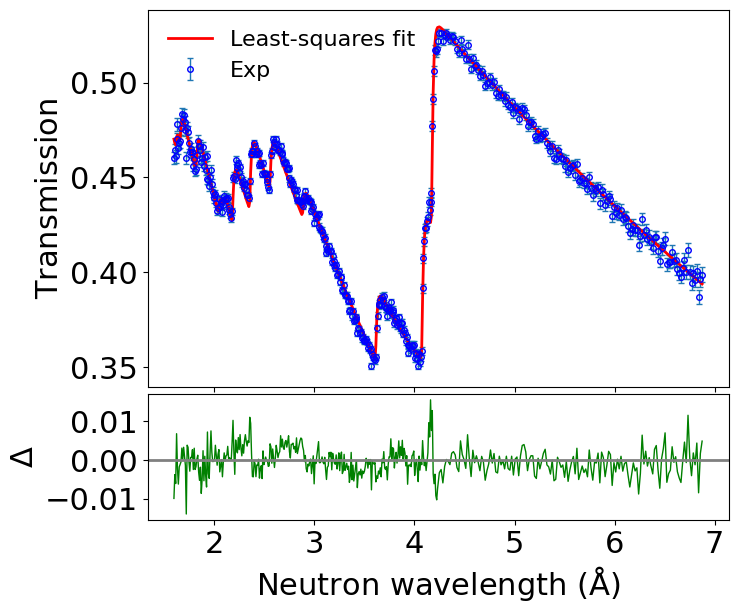

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6),
                               sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 0.25], 'hspace': 0.03})

# Top subplot: Data with error bars and fit line
ax1.errorbar(wavelength, trans_exp[:, 1], yerr=trans_exp[:, 2],
             fmt='o', markerfacecolor='none', markeredgecolor='blue',
             markersize=4, capsize=2, capthick=1, elinewidth=1,
             label='Exp')

ax1.plot(wavelength, result.best_fit,
         color='red', linewidth=2,
         label='Least-squares fit')

# Bottom subplot: Residuals
ax2.plot(wavelength, trans_exp[:, 1] - result.best_fit,
         color='green', linewidth=1)
ax2.axhline(y=0., color='grey', linewidth=2)

# Configure x-axis
ax2.set_xlabel(r'$\mathrm{Neutron\ wavelength\ (\AA)}$', fontsize=22, fontfamily='Times New Roman')

ax1.tick_params(labelsize=22)
ax2.tick_params(labelsize=22)

# Configure y-axes
ax1.set_ylabel(r'$\mathrm{Transmission}$', fontsize=22, fontfamily='Times New Roman')
ax2.set_ylabel(r'$\Delta$', fontsize=22, fontfamily='Times New Roman')

# Legend (similar to your Plotly settings)
ax1.legend(loc='upper left', frameon=True, framealpha=0,
          edgecolor='black', facecolor='white', fontsize=16)

# Set transparent background
fig.patch.set_alpha(0)
ax1.patch.set_alpha(0)
ax2.patch.set_alpha(0)

# Adjust layout margins
plt.tight_layout()
plt.subplots_adjust(left=0.12, right=0.95, bottom=0.1, top=0.95)

# Show/save the figure
plt.show()